# MSCA 31008 - Data Mining Assignment 2 (Group 4)
<b>Prinu Mathew, Qingwei Zhang, Jake Brewer</b><br>
<b>Winter 2023</b>

### Import Libraries  

In [1]:
import sys, os, json, subprocess

## for data
import pandas as pd
import numpy as np
import datetime

## for machine learning
from scipy import stats
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings('ignore')

In [2]:
## for machine learning
try:
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.cluster import KMeans
    from sklearn.mixture import GaussianMixture
    import sklearn.datasets
        
    print("~~~ Already installed required packages for machine learning ~~~~")
except Exception as e:
    print(e)
    
    print("~~~ Installing required packages for machine learning ~~~~")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "scikit-learn"])
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.cluster import KMeans
    from sklearn.mixture import GaussianMixture
    import sklearn.datasets

~~~ Already installed required packages for machine learning ~~~~


In [3]:
## for interactive visualization
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    print("~~~ Already installed required packages for interactive visualizations ~~~~")
except Exception as e:
    print(e)
    
    print("~~~ Installing required packages for interactive visualizations ~~~~")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "matplotlib"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "seaborn"])
    import matplotlib.pyplot as plt
    import seaborn as sns
    
%matplotlib inline

~~~ Already installed required packages for interactive visualizations ~~~~


## 1. Read dataset
Include all variables except for MEDV (Median value of owner-occupied homes in $1000's). Since MEDV typically would be the target variable that we want to predict we should exclude it so that the clusters only consist of predictor variables.

In [4]:
# reading the CSV file
input_df = pd.read_csv('BostonHousing.csv', quotechar='"', delimiter = ',')
input_df.head(10)
X = input_df.drop(columns=['MEDV'])
input_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## 2. Scale the Data Using MinMaxScaler

In [5]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33


In [6]:
# split data into training and testing and scale using Min-Max scaling
X_train, X_test = train_test_split(X, test_size=.3, random_state=50)

scaler  = MinMaxScaler(feature_range=(0, 1))
model=scaler.fit(X_train) # fit just to train data
X_train = model.transform(X_train) # transform train using fitted train
X_test = model.transform(X_test) # transform test using fitted train

In [7]:
X_train

array([[2.33528471e-03, 2.20000000e-01, 1.97947214e-01, ...,
        6.91489362e-01, 9.49708344e-01, 5.27659574e-02],
       [2.92795719e-04, 0.00000000e+00, 6.30498534e-02, ...,
        6.48936170e-01, 9.94242962e-01, 3.43262411e-02],
       [6.80252688e-03, 2.00000000e-01, 1.28665689e-01, ...,
        4.25531915e-02, 9.81739792e-01, 9.61702128e-02],
       ...,
       [9.79031331e-02, 0.00000000e+00, 6.46627566e-01, ...,
        8.08510638e-01, 9.87522191e-01, 4.36595745e-01],
       [6.53894329e-02, 0.00000000e+00, 6.46627566e-01, ...,
        8.08510638e-01, 1.00000000e+00, 2.55602837e-01],
       [7.18220593e-04, 0.00000000e+00, 1.31598240e-01, ...,
        4.25531915e-01, 9.90692366e-01, 2.37730496e-01]])

## 3. Generate K-Means Solutions with 2-10 Clusters
Distortion: It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used.<br>
Inertia: It is the sum of squared distances of samples to their closest cluster center.

In [8]:
# run kmeans with various number of clusters
distortions = []
inertias = []
clus_size = []
centroids = []
mapping1 = {}
mapping2 = {}
K = range(2, 11)

for i in K:
    kmeans = KMeans(n_clusters=i, n_init=100, random_state=50)
    kmeans.fit(X_train)
    kmeans.transform(X_train)
    distortions.append(sum(np.min(cdist(X_train, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeans.inertia_)
    mapping1[i] = sum(np.min(cdist(X_train, kmeans.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[i] = kmeans.inertia_
    clust_size_dict = {}
    for j in range(0, i):
        clust_size_dict[j] = len(kmeans.predict(X_train)[kmeans.predict(X_train) == j]) / len(X_train)
    clus_size.append(clust_size_dict)
    centroids.append(kmeans.cluster_centers_)

## 4-5. Perform Scree Tests / Show Scree Plot

### Using the different values of Distortion:

In [9]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

2 : 0.42509465943768554
3 : 0.37097522639190705
4 : 0.34346453538774296
5 : 0.32597533067258705
6 : 0.30009531693167635
7 : 0.2798703447566895
8 : 0.26660812711799586
9 : 0.25597376441677705
10 : 0.250170229334477


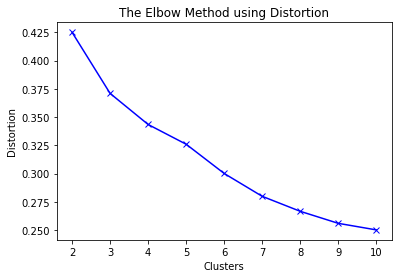

In [10]:
# scree plot
fig, ax = plt.subplots()

ax.plot(K, distortions, 'bx-')
plt.xlabel('Clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

### Using the different values of Inertia:

In [11]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

2 : 151.65902250723494
3 : 116.52083192252748
4 : 99.19104266045733
5 : 86.87658458549909
6 : 75.23641392977636
7 : 65.80642352721887
8 : 59.77664401063546
9 : 55.185519870067395
10 : 52.01604543709525


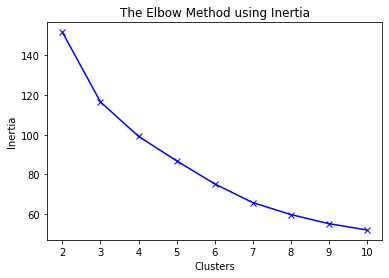

In [12]:
# scree plot
fig, ax = plt.subplots()

ax.plot(K, inertias, 'bx-')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

### Interpretation of Scree Plot
 
From above visual interpretation, to determine the optimal number of clusters, we have to select the value of k at the “elbow” ie the point after which the distortion/inertia start decreasing in a linear fashion. Thus for the given data, we conclude that the optimal number of clusters for the data is 3.

## 6. Run KMeans on Test Data and Compare Results to KMeans on Train Data